##Accessing google drive:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import pickle
import os
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Importing classes and functions in "my_classes.py" and "ResNet_implementation.py" files.
exec(open("/content/gdrive/My Drive/ResNet_CIFAR10/code/ResNet_implementation.py").read())
exec(open("/content/gdrive/My Drive/ResNet_CIFAR10/code/my_classes.py").read())

## Extracting files: 


In [ ]:
file_name= "/content/gdrive/My Drive/ResNet_CIFAR10/data/cifar-10-python.tar.gz"   #the directory in which the data set is
if file_name.endswith("tar.gz"):
    tar = tarfile.open(file_name, "r:gz")
    tar.extractall(path="/content/gdrive/My Drive/ResNet_CIFAR10/data")
    tar.close()
elif file_name.endswith("tar"):
    tar = tarfile.open(file_name, "r:")
    tar.extractall(path="/content/gdrive/My Drive/ResNet_CIFAR10/data")
    tar.close()

In [ ]:
#creating a list of dictionaries:
#Each data batch will be loaded as a dictionary and data_list contains all of these dictionaries.
#Each of the dictionaries contains the data, labels as well as the file names. It also has the batch number which is a number between 1 and 5.

data_list=[]
for i in range(1,6):
    with open("/content/gdrive/My Drive/ResNet_CIFAR10/data/cifar-10-batches-py/data_batch_"+str(i), 'rb') as f:
        data_list.append(pickle.load(f, encoding='bytes'))
 
print("keys of the inner dictionaries:",list(data_list[0].keys()))
print("shape of each data batch: ",data_list[0][b'data'].shape)

#################################################################################################
#Concatenating the batches to get a training set of size (50000,3072) .
X_train = data_list[0][b'data']
y_train = np.array(data_list[0][b'labels'])

for i in range(1,5):
    X_train = np.concatenate((X_train,data_list[i][b'data']), axis=0)
    y_train = np.concatenate((y_train,data_list[i][b'labels']), axis=0)

print()
print("shape of the data set: ", X_train.shape)
print("shape of the training set labels: ",y_train.shape)

################################################################################################
#Loading the test set:
with open("/content/gdrive/My Drive/ResNet_CIFAR10/data/cifar-10-batches-py/test_batch", 'rb') as f:
    data=pickle.load(f, encoding='bytes')
                
X_test = data[b'data']
y_test= np.array(data[b'labels'])

print()
print("shape of the test set: ", X_test.shape)
print("shape of the test set labels: ",y_test.shape)


keys of the inner dictionaries: [b'batch_label', b'labels', b'data', b'filenames']
shape of each data batch:  (10000, 3072)

shape of the data set:  (50000, 3072)
shape of the training set labels:  (50000,)

shape of the test set:  (10000, 3072)
shape of the test set labels:  (10000,)


##Reshaping each sample to get 32x32x3 images:

In [ ]:
X_train_temp=np.zeros((X_train.shape[0],32,32,3))
X_test_temp=np.zeros((X_test.shape[0],32,32,3))

X_train_temp[:,:,:,0] = np.array([np.reshape(X_train[i,0:1024],(32,32)) for i in range(X_train.shape[0])])
X_train_temp[:,:,:,1] = np.array([np.reshape(X_train[i,1024:2048],(32,32)) for i in range(X_train.shape[0])])
X_train_temp[:,:,:,2] = np.array([np.reshape(X_train[i,2048:3072],(32,32)) for i in range(X_train.shape[0])])
X_train=X_train_temp.astype(int)

X_test_temp[:,:,:,0] = np.array([np.reshape(X_test[i,0:1024],(32,32)) for i in range(X_test.shape[0])])
X_test_temp[:,:,:,1] = np.array([np.reshape(X_test[i,1024:2048],(32,32)) for i in range(X_test.shape[0])])
X_test_temp[:,:,:,2] = np.array([np.reshape(X_test[i,2048:3072],(32,32)) for i in range(X_test.shape[0])])
X_test=X_test_temp.astype(int)

print("shape of training set: ",X_train.shape)
print("shape of test set: ",X_test.shape)

shape of training set:  (50000, 32, 32, 3)
shape of test set:  (10000, 32, 32, 3)


##Visualizing a few samples:

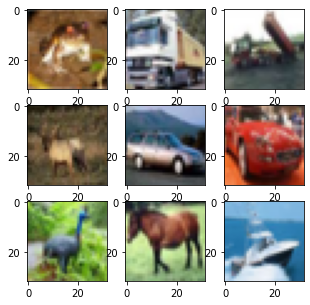

In [ ]:
fig, ax= plt.subplots(3,3,figsize=(5,5))
for i in range(0,3):
    for  j in range(0,3):
        ax[i,j].imshow(X_train[(i*(3))+j])

plt.show()

# ResNet model:

- I have tried to implement the model as close to the architecture in the paper as possible, but there might be some mistakes!

- Please check the "ResNet_implementation.py" file to see how the model is implemented.

##**Article's title:**

**ResNet Based on the "K. He, X. Zhang, S. Ren, and J. Sun. Deep residual learning for image recognition.**

link: https://arxiv.org/abs/1512.03385**




In [ ]:
model=ResNet((32,32,3), stages_residual_blocks=[3, 4, 6, 3], num_classes=10)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Training the model:

In [ ]:
def train_ResNet_from_scratch(X_train, X_test, y_train, y_test, model, callbacks, data_aug=False):
      if data_aug == False:
          X_train_ResNet=X_train/255
          X_test_ResNet= X_test/255
          model.fit(X_train_ResNet,y_train,batch_size=128, epochs=120, verbose=1, callbacks=callbacks, 
                              validation_data= (X_test_ResNet, y_test), shuffle=True)
      else:
          train_datagen=ImageDataGenerator(rescale=1./255, rotation_range=25, width_shift_range= 0.2, height_shift_range= 0.2, shear_range= 0.2, 
                                           zoom_range= 0.2, horizontal_flip= True, fill_mode= 'nearest')
          val_datagen= ImageDataGenerator(rescale=1./255)
          train_generator=train_datagen.flow(X_train,y_train, batch_size=128)
          val_generator=val_datagen.flow(X_test,y_test,batch_size=128) 
          model.fit(train_generator, epochs=120, verbose=1, callbacks=callbacks, validation_data= val_generator)



## Training the model with data augmentation:

In [ ]:
model_saver=SaveModel("/content/gdrive/My Drive/ResNet_CIFAR10/ResNet_with_Augmentation",every=20,start_at=0)
my_plot= MyPlot("/content/gdrive/My Drive/ResNet_CIFAR10/ResNet_with_Augmentation/figure", "/content/gdrive/My Drive/ResNet_CIFAR10/ResNet_with_Augmentation/history.pickle", start_at=0)
LRD= LearningRateDecay()
callbacks=[model_saver, my_plot, LRD]

In [ ]:
train_ResNet_from_scratch(X_train, X_test, y_train, y_test, model=model, callbacks=callbacks, data_aug=True)

Epoch 1/120
391/391 [==============================] - 80s 204ms/step - loss: 3.7276 - accuracy: 0.3318 - val_loss: 3.2867 - val_accuracy: 0.4253
Epoch 2/120
391/391 [==============================] - 81s 206ms/step - loss: 3.3138 - accuracy: 0.4177 - val_loss: 3.2252 - val_accuracy: 0.4423
Epoch 3/120
391/391 [==============================] - 82s 209ms/step - loss: 3.1730 - accuracy: 0.4617 - val_loss: 3.1973 - val_accuracy: 0.4550
Epoch 4/120
391/391 [==============================] - 82s 209ms/step - loss: 3.0674 - accuracy: 0.4915 - val_loss: 2.9697 - val_accuracy: 0.5395
Epoch 5/120
391/391 [==============================] - 82s 210ms/step - loss: 2.9581 - accuracy: 0.5232 - val_loss: 2.7865 - val_accuracy: 0.5826
Epoch 6/120
391/391 [==============================] - 82s 210ms/step - loss: 2.8833 - accuracy: 0.5414 - val_loss: 2.9236 - val_accuracy: 0.5531
Epoch 7/120
391/391 [==============================] - 82s 210ms/step - loss: 2.7922 - accuracy: 0.5692 - val_loss: 2.7569 -